In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P4


In [0]:
# Step 1: Load the data and transform dataset
# Using 300x300 images with random horizontal flip, random rotation and normalization
dataset_dir = "/content/drive/My Drive/Colab Notebooks/DataSet/car_data"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"/train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"/test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

In [0]:
# Step 2: Create a Model training function
# Train model, after each epoch, we test the model on the test data to see how it's going
n_epochs = 10

def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies


In [0]:
# Step 3: Evaluate training data
# This function is called out after each epoch of training on the training data. We then measure the accuracy of the model
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [10]:
# Step 4: Create a Model
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s]


In [0]:
# Step 5: Train Model
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 1403 s, loss: 4.0138, acc: 15.3922
Accuracy of the network on the test images: 34 %
Epoch 2, duration: 137 s, loss: 1.6660, acc: 56.8750
Accuracy of the network on the test images: 50 %
Epoch 3, duration: 134 s, loss: 0.8711, acc: 76.1520
Accuracy of the network on the test images: 66 %
Epoch 4, duration: 135 s, loss: 0.5489, acc: 84.7426
Accuracy of the network on the test images: 72 %
Epoch 5, duration: 135 s, loss: 0.3759, acc: 89.2157
Accuracy of the network on the test images: 73 %
Epoch 6, duration: 133 s, loss: 0.2539, acc: 93.0025
Accuracy of the network on the test images: 80 %
Epoch 7, duration: 133 s, loss: 0.1683, acc: 95.4167
Accuracy of the network on the test images: 84 %
Epoch 8, duration: 134 s, loss: 0.0843, acc: 98.0882
Accuracy of the network on the test images: 89 %
Epoch 9, duration: 134 s, loss: 0.0548, acc: 98.8725
Accuracy of the network on the test images: 90 %
Epoch 10, duration: 133 s, loss: 0.0488, acc: 99.0319
Accuracy of the network on 

In [0]:
# Step 6: Save the Model
# Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
checkpoint = {'state_dict': model_ft.state_dict(),
              'model': model_ft.fc,
              'class_to_idx': dataset.class_to_idx,
              'opt_state': optimizer.state_dict,
              'model_ft':model_ft,
              'epoch': n_epochs,
              'training_losses':training_losses,
              'training_accs':training_accs,
              'test_accs':test_accs}

torch.save(checkpoint, '/content/drive/My Drive/Colab Notebooks/mycar_checkpoint1.pth')

In [11]:
# Step 7: Load the Model
# Write a function that loads a checkpoint and rebuilds the model

# Loading model
# Checking model i.e. should have 196 output units in the classifier
checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/mycar_checkpoint1.pth')
    
#model.load_state_dict(checkpoint['state_dict'])
model_ft.load_state_dict(checkpoint['state_dict'], strict=False)
model_ft.class_to_idx = checkpoint['class_to_idx']
training_losses = checkpoint['training_losses']
training_accs = checkpoint['training_accs']
test_accs = checkpoint['test_accs']

#Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
model_ft.eval()
print(model_ft)
 #   return model_ft


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Text(0.5, 1.0, 'Test acc')

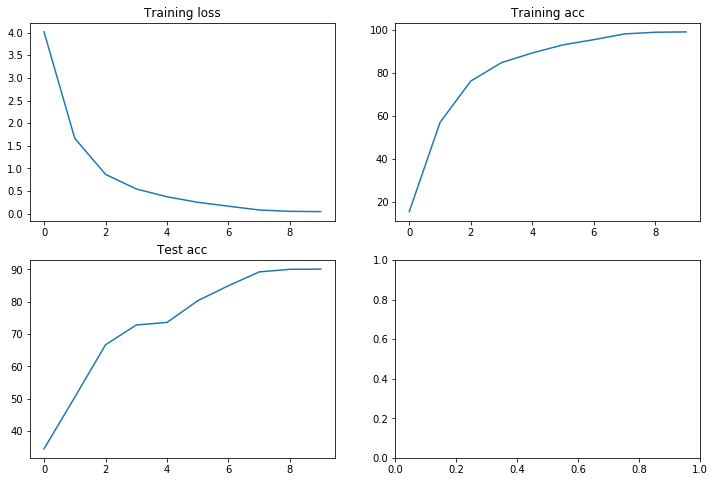

In [12]:
# Step 8: Draw plot the stats
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

In [25]:
# Step 9: Predict the Image
# tie the class indices to their names
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"/train")
print(classes, c_to_idx)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

In [0]:
# test the model on random images

# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"/test/car_random/audi A3 2012.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

In [0]:
# Step 10: Show the result
# get the class name of the prediction
display(Image.open(dataset_dir+"/test/car_random/audi A3 2012.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())